# HW02 Sentiment Analysis

In [1]:
# Import necessary libraries
import nltk, os, re
import scipy
import pandas as pd
import numpy as np
from tqdm import tqdm
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import random, pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [2]:
# Setting necessary constants
files = ['positive', 'negative']
categories = ['books', 'dvd', 'kitchen', 'electronics']
characters_to_remove = '!()#@~"'
pattern = "[" + characters_to_remove + "]"
classifiers = ['NB', 'LR','DT', 'RF']
datasets = ['books', 'dvd', 'electronics', 'kitchen', 'all']
features = ['bow', 'bool-bow', 'lexicon']
n_estimators = np.sort(random.sample(range(1, 1000), 50))
parameters = {
    'n_estimators': n_estimators,
    'max_features': ('auto', 'sqrt', 'log2'),
}
scores = ['precision', 'recall']

### Loading lexicons

In [3]:
# Reading SentiWordNet lexicon
neg_score = {}
pos_score = {}
with open('./data/EN_Lexicons/SentiWordNet_3.0.0.txt') as file:
    for i, line in enumerate(file):
        if line[0] == '#':
            continue
        else:
            try:
                splitted = line.split('\t')[:5]
                pos = {splitted[-1].split('#')[0]: float(splitted[2])}
                neg = {splitted[-1].split('#')[0]: float(splitted[3])}
                neg_score.update(neg)
                pos_score.update(pos)
            except:
                pass

In [4]:
# Reading AFINN lexicon
ANFII = {}
with open('./data/EN_Lexicons/AFINN-111.txt') as file:
    for line in file:
        item = line.strip('\n').split('\t')
        d = {item[0]: int(item[1])}
        ANFII.update(d)

In [5]:
# Reading WordStat lexicon 
word_stat_pos = []
word_stat_neg = []
neg_words = False
pos_words = False
with open('./data/EN_Lexicons/WordStat Sentiments.txt') as file:
    for i, line in enumerate(file):
        if line.strip('\t').replace(' ', '_').replace('\n', '') == 'NEGATIVE_WORDS':
            neg_words = True
        if neg_words:
            word_stat_neg.append(line.strip('\t').split(' ')[0].replace(' ','_').lower())
        if line.strip('\t').replace(' ', '_').replace('\n', '') == 'POSITIVE_WORDS':
            neg_words = False
            pos_words = True
        if pos_words:
            word_stat_pos.append(line.strip('\t').split(' ')[0].replace(' ','_').lower())

In [6]:
# Reading senticnet5.py lexicon
%run ./data/EN_Lexicons/senticnet5.py

### Function definition

In [7]:
def read_file(category, file):
    """ Reads a review file and orders dictionary, documents and tags
    
    Args:
        category (str): category to be read
        file (str): file to be read
    
    Returns:
        list: list containing the words found in the file
        list: list containing one dictionary per review with words and associated frequency
        list: list with the tag associated to each document
    """
    
    words = []
    docs = []
    tags = []
    with open('./data/SA/'+category+'/'+file+'.review', encoding='ISO-8859-1') as file:
        for line in file:
            words_and_freq = re.sub(pattern, "", line.strip('\n').strip('\x1a')).split('label:')
            if words_and_freq[-1] == 'positive':
                tag = int(1)
            else:
                tag = int(0)
            tags.append(tag)
            words_and_freq = words_and_freq[0].split(' ')
            d = {}
            for term in words_and_freq[:-1]:
                split = term.split(':')
                words.append(split[0])
                x = {split[0]:int(split[1])}
                d.update(x)
            docs.append(d)
    return [words, docs, tags]

def build_dataset(category):
    """ Given a category returns the necessary data to build the dataset
    
    Args:
        category (str): Category from which to build dataset
        
    Returns:
        'numpy.ndarray': dictionay associated to the given category
        list: one dictionary per review
        list: tag per document
        list: one dictionary per review in unlabeled file
        list: tag per document in unlabeled file
    """
    
    dictionary = []
    documents = []
    tags = []
    for file in files:
        [words_temp, docs_temp, tags_temp] = read_file(category, file)
        words_temp = np.unique(words_temp)
        for term in zip(docs_temp, tags_temp):
            documents.append(term[0])
            tags.append(term[1])
        for word in words_temp:
            dictionary.append(word)
    temp, unlabeled_docs, unlabeled_tags = read_file(category, 'unlabeled')
    return [np.array(np.unique(dictionary),dtype='str'), documents, tags, unlabeled_docs, unlabeled_tags]
  
def purge_dataset(dictionary, documents):
    """ Removes the words with unitary frequency
    
    Args:
        dictionary ('numpy.ndarray'): dictionary to be purged
        documents (list): base list to define word frequency
        
    Returns:
        'numpy.ndarray': purged dictionary
    """
    
    freq = np.zeros(len(dictionary))
    for i, word in enumerate(dictionary):
        for doc in documents:
            try:
                freq[i] = freq[i] + doc[word]
            except:
                pass
    to_remove = []
    for i, occurence in enumerate(zip(dictionary, freq)):
        if occurence[1] == 1:
            to_remove.append(i)
    dictionary = np.delete(dictionary, to_remove)
    return dictionary

def build_matrix(dictionary, documents, tags, unlabeled_docs, unlabeled_tags, file, boolean):
    """ Given dictionary and document arrays builds the according BOW
    
    Args:
        dictionary ('numpy.ndarray'): associated dictionary
        documents (list): dictionary per review
        tags (list): tag per review
        unlabeled_docs (list): dictioray per ulabeled review
        unlabeled_tags (list): tag per unlabeded review
        file (str): name of the file (labeled or not)
        boolean (str): type of BOW expected
        
    Returns:
        'numpy.matrix': matrix with BOW and tag per document
    """
    
    if file == 'labeled':
        m = np.zeros((len(dictionary) + 1, len(documents)), dtype = np.bool_ if boolean == 'bool' else np.int8)
        for i, document in enumerate(documents):
            for key in document.keys():
                index = np.where(dictionary == key)[0]
                if len(index) != 0:
                    m[index[0],i] = True if boolean == 'bool' else document[key]
            m[-1, i] = tags[i]
    else:
        m = np.zeros((len(dictionary) + 1, len(unlabeled_docs)), dtype = np.bool_ if boolean == 'bool' else np.int8)
        for i, document in enumerate(unlabeled_docs):
            for key in document.keys():
                index = np.where(dictionary == key)[0]
                if len(index) != 0:
                    m[index[0],i] = True if boolean == 'bool' else document[key]
            m[-1, i] = unlabeled_tags[i]
    return m

def set_values(pos_count, neg_count, polarity_last, pos_sum, neg_sum, ANFII_pos_count, ANFII_neg_count, 
                      ANFII_pos_score, ANFII_neg_score, stat_pos, stat_neg, polarity_senticnet, file):
    """ Returns and array of values with the lexicon extracted features
    
    Args:
        pos_count (int): count of positive words according to SentiWordNet
        neg_count (int): count of negative words according to SentiWordNet
        polarity_last (float): polarity of the last word according to SentiWordNet
        pos_sum (float): sum of the polarity of the positive words according to SentiWordNet
        neg_sum (float): sum of the polatiry of the negative words according to SentiWordNet
        ANFII_pos_count (int): count of positive words according to ANFII
        ANFII_neg_count (int): count of negative words according to ANFII
        ANFII_pos_score (int): sum of positive words according to ANFII
        ANFII_neg_score (int): sum of negative words according to ANFII
        stat_pos (int): count of positive words according to statWord
        stat_neg (int): count of negative words according to statWord
        polarity_senticnet (float): Polarity of the words according to senticnet
        file (str): Name of the file to set the tag
        
    Returns:
        'nump.ndarray': Array with all parameters organized
    """
    
    if neg_count == 0:
        div = 0
    else:
        div = pos_count/neg_count
    if file == 'positive':
        tag = 1
    else:
        tag = 0
    return np.array([pos_count, neg_count, polarity_last, pos_sum, neg_sum, ANFII_pos_count, ANFII_neg_count, 
                      ANFII_pos_score, ANFII_neg_score, stat_pos, stat_neg, polarity_senticnet, tag])

def create_lexicon_vector(doc, file):
    """ Extracts lexicon based features from doc
    
    Args:
        doc (dict): Dictionary with document from with to extract lexicon features
        file (str): file from wich the document came from
    
    Retuns:
        'numpy.ndarray': values to be appended in lexicon matrix
    """
    
    neg_count = pos_count = neg_sum = pos_sum = 0
    ANFII_pos_count = ANFII_neg_count = ANFII_pos_score = ANFII_neg_score = 0
    stat_pos = stat_neg = polarity_senticnet = 0
    last_word = True; word_in_lex = False
    words = list(doc.keys())
    polarity_last = 0
    for word in reversed(words):
        list_words = word.split('_')
        for list_word in list_words:
            if list_word in neg_score.keys():
                if neg_score[list_word] > 0:
                    neg_count += 1
                    neg_sum += neg_score[list_word]
                    word_in_lex = True
                if pos_score[list_word] > 0:
                    pos_count += 1
                    pos_sum += pos_score[list_word]
                    word_in_lex = True
                if word_in_lex and last_word:
                    polarity_last = (neg_score[list_word]*-1) + (pos_score[list_word])
                    last_word = False
            if list_word in ANFII.keys():
                if ANFII[list_word] > 0:
                    ANFII_pos_count += 1
                    ANFII_pos_score += ANFII[list_word]
                else:
                    ANFII_neg_count += 1
                    ANFII_neg_score += ANFII[list_word]
            if list_word in word_stat_pos:
                stat_pos += 1
            elif list_word in word_stat_neg:
                stat_neg += 1
            if list_word in list(senticnet.keys()):
                polarity_senticnet += float(senticnet[list_word][7])
    return set_values(pos_count, neg_count, polarity_last, pos_sum, neg_sum, ANFII_pos_count, ANFII_neg_count, 
                      ANFII_pos_score, ANFII_neg_score, stat_pos, stat_neg, polarity_senticnet, file)

### Build bool and not-bool BOW

In [8]:
# Creates bool BOW and non-bool BOW matrices for each category
for cat in tqdm(categories):
    [dictionary, documents, tags, unlabeled_docs, unlabeled_tags] = build_dataset(cat)
    dictionary = purge_dataset(dictionary, documents)
    np.save('./data/SA/'+cat+'/dictionary.npy', dictionary)
    ans = build_matrix(dictionary, documents, tags, unlabeled_docs, unlabeled_tags, 'labeled', 'bool')
    np.save('./data/SA/'+cat+'/bool-labeled.npy',ans)
    ans = build_matrix(dictionary, documents, tags, unlabeled_docs, unlabeled_tags, 'unlabeled', 'not-bool')
    np.save('./data/SA/'+cat+'/unlabeled.npy',ans)
    ans = build_matrix(dictionary, documents, tags, unlabeled_docs, unlabeled_tags, 'labeled', 'not-bool')
    np.save('./data/SA/'+cat+'/labeled.npy',ans)
    ans = build_matrix(dictionary, documents, tags, unlabeled_docs, unlabeled_tags, 'unlabeled', 'bool')
    np.save('./data/SA/'+cat+'/bool-unlabeled.npy',ans)

100%|██████████| 4/4 [53:36<00:00, 804.16s/it]   


In [9]:
# Creates dictionary for all categories together
dictionary = np.concatenate((np.load('./data/SA/books/dictionary.npy'),
                            np.load('./data/SA/dvd/dictionary.npy'),
                            np.load('./data/SA/electronics/dictionary.npy'),
                            np.load('./data/SA/kitchen/dictionary.npy')), axis = 0)
dictionary = np.array(np.unique(dictionary),dtype='str')
print(dictionary.shape)

(100801,)


In [10]:
# Creates dictionary matrices for books category based on whole dictionary
[dictionary1, documents, tags, unlabeled_docs, unlabeled_tags] = build_dataset('books')
np.save('./data/SA/all/bool-labeled.npy', build_matrix(dictionary, documents, tags, unlabeled_docs, unlabeled_tags, 'labeled', 'bool'))
np.save('./data/SA/all/bool-unlabeled.npy', build_matrix(dictionary, documents, tags, unlabeled_docs, unlabeled_tags, 'unlabeled', 'bool'))
np.save('./data/SA/all/labeled.npy', build_matrix(dictionary, documents, tags, unlabeled_docs, unlabeled_tags, 'labeled', 'not-bool'))
np.save('./data/SA/all/unlabeled.npy', build_matrix(dictionary, documents, tags, unlabeled_docs, unlabeled_tags, 'unlabeled', 'not-bool'))

In [11]:
# Creates dictionary matrices for dvd category based on whole dictionary
[dictionary1, documents, tags, unlabeled_docs, unlabeled_tags] = build_dataset('dvd')
m = np.load('./data/SA/all/bool-labeled.npy')
np.save('./data/SA/all/bool-labeled.npy', 
        np.concatenate((m, build_matrix(dictionary, documents, tags, unlabeled_docs, unlabeled_tags, 'labeled', 'bool')), axis = 1))
m = np.load('./data/SA/all/bool-unlabeled.npy')
np.save('./data/SA/all/bool-unlabeled.npy',
        np.concatenate((m, build_matrix(dictionary, documents, tags, unlabeled_docs, unlabeled_tags, 'unlabeled', 'bool')), axis = 1))
m = np.load('./data/SA/all/labeled.npy')
np.save('./data/SA/all/labeled.npy',
        np.concatenate((m, build_matrix(dictionary, documents, tags, unlabeled_docs, unlabeled_tags, 'labeled', 'not-bool')), axis = 1))
m = np.load('./data/SA/all/unlabeled.npy')
np.save('./data/SA/all/unlabeled.npy', 
        np.concatenate((m, build_matrix(dictionary, documents, tags, unlabeled_docs, unlabeled_tags, 'unlabeled', 'not-bool')), axis = 1))

In [12]:
# Creates dictionary matrices for electronics category based on whole dictionary
[dictionary1, documents, tags, unlabeled_docs, unlabeled_tags] = build_dataset('electronics')
m = np.load('./data/SA/all/bool-labeled.npy')
np.save('./data/SA/all/bool-labeled.npy', 
        np.concatenate((m, build_matrix(dictionary, documents, tags, unlabeled_docs, unlabeled_tags, 'labeled', 'bool')), axis = 1))
m = np.load('./data/SA/all/bool-unlabeled.npy')
np.save('./data/SA/all/bool-unlabeled.npy',
        np.concatenate((m, build_matrix(dictionary, documents, tags, unlabeled_docs, unlabeled_tags, 'unlabeled', 'bool')), axis = 1))
m = np.load('./data/SA/all/labeled.npy')
np.save('./data/SA/all/labeled.npy',
        np.concatenate((m, build_matrix(dictionary, documents, tags, unlabeled_docs, unlabeled_tags, 'labeled', 'not-bool')), axis = 1))
m = np.load('./data/SA/all/unlabeled.npy')
np.save('./data/SA/all/unlabeled.npy', 
        np.concatenate((m, build_matrix(dictionary, documents, tags, unlabeled_docs, unlabeled_tags, 'unlabeled', 'not-bool')), axis = 1))

In [13]:
# Creates dictionary matrices for kitchen category based on whole dictionary
[dictionary1, documents, tags, unlabeled_docs, unlabeled_tags] = build_dataset('kitchen')
m = np.load('./data/SA/all/bool-labeled.npy')
np.save('./data/SA/all/bool-labeled.npy', 
       np.concatenate((m, build_matrix(dictionary, documents, tags, unlabeled_docs, unlabeled_tags, 'labeled', 'bool')), axis = 1))
m = np.load('./data/SA/all/bool-unlabeled.npy')
np.save('./data/SA/all/bool-unlabeled.npy',
        np.concatenate((m, build_matrix(dictionary, documents, tags, unlabeled_docs, unlabeled_tags, 'unlabeled', 'bool')), axis = 1))
m = np.load('./data/SA/all/labeled.npy')
np.save('./data/SA/all/labeled.npy',
        np.concatenate((m, build_matrix(dictionary, documents, tags, unlabeled_docs, unlabeled_tags, 'labeled', 'not-bool')), axis = 1))
m = np.load('./data/SA/all/unlabeled.npy')
np.save('./data/SA/all/unlabeled.npy', 
        np.concatenate((m, build_matrix(dictionary, documents, tags, unlabeled_docs, unlabeled_tags, 'unlabeled', 'not-bool')), axis = 1))

In [14]:
# Saves complete dictionary
np.save('./data/SA/all/dictionary.npy', dictionary)

### Creates lexicon matrices

In [15]:
# Creates matrices with lexicon extracted features
for cat in tqdm(['books', 'dvd', 'electronics', 'kitchen']):
    m = np.zeros((1,13))
    for file in ['positive', 'negative']:
        words, docs, tags = read_file('books', file)
        for doc in docs:
            n = np.reshape(create_lexicon_vector(doc, file), (1,13))
            m = np.append(m, n, axis=0)
    m[~np.all(m == 0, axis=1)]
    np.save('./data/SA/'+cat+'/lexicon-labeled.npy', np.transpose(m[1:,:]))
    words, docs, tags = read_file('books', 'unlabeled')
    m = np.zeros((1,13))
    for doc in docs:
        n = np.reshape(create_lexicon_vector(doc, file), (1,13))
        m = np.append(m, n, axis=0)
    m[~np.all(m == 0, axis=1)]
    np.save('./data/SA/'+cat+'/lexicon-unlabeled.npy', np.transpose(m[1:,:]))

100%|██████████| 4/4 [11:00:06<00:00, 9901.72s/it] 


In [16]:
# Creates matrices of lexicon extracted features for all categories together
np.save('./data/SA/all/lexicon-labeled.npy', np.concatenate((np.load('./data/SA/books/lexicon-labeled.npy'),
                                                             np.load('./data/SA/dvd/lexicon-labeled.npy'),
                                                             np.load('./data/SA/electronics/lexicon-labeled.npy'),
                                                             np.load('./data/SA/kitchen/lexicon-labeled.npy')), 
                                                             axis=1))

np.save('./data/SA/all/lexicon-unlabeled.npy', np.concatenate((np.load('./data/SA/books/lexicon-unlabeled.npy'),
                                                             np.load('./data/SA/dvd/lexicon-unlabeled.npy'),
                                                             np.load('./data/SA/electronics/lexicon-unlabeled.npy'),
                                                             np.load('./data/SA/kitchen/lexicon-unlabeled.npy')), 
                                                             axis=1))

### Classifiers training

In [3]:
LR_coeffs = []
parameters = {
    'n_estimators': scipy.stats.uniform(loc=1, scale = 999),
    'max_features': ('auto', 'sqrt', 'log2'),
    'criterion': ('gini', 'entropy'),
    'max_depth': scipy.stats.uniform(loc=1, scale = 999),
    'min_leaf_nodes': scipy.stats.uniform(loc=1, scale=999)
}
scores = ['precision', 'recall']
from sklearn.model_selection import RandomizedSearchCV

In [4]:
def train_validate_evaluate(classifier, dataset, feature):
    """ Trains and evaluates specified classifier
    
    Args:
        classifier (str): initials of classifier
        dataset (str): category to be trained on
        feature (str): file to use as training data
        
    Returns:
        'pandas.dataframe': Dataframe containing metrics for each classifier    
    """
    
    if feature == 'bow':
        item = ''
    elif feature == 'bool-bow':
        item = 'bool-'
    else:
        item = 'lexicon-'
    path = './data/SA/' + dataset + '/' + item + 'labeled.npy'
    data = np.transpose(np.load(path))
    X = data[:,:-1]
    y = data[:,-1]
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=15)
    if classifier == 'NB':
        clf = GaussianNB()
    elif classifier == 'LR':
        clf = LogisticRegression(random_state=0, max_iter=500)
    elif classifier == 'DT':
        clf = DecisionTreeClassifier(random_state=0)
    elif classifier == 'RF':
        clf = RandomForestClassifier()
    clf.fit(X_train, y_train)
    if classifier == 'LR':
        LR_coeffs.append(clf.coef_)
    y_pred = clf.predict(X_val)
    accuracy = metrics.accuracy_score(y_val, y_pred)
    precision = metrics.precision_score(y_val, y_pred)
    recall = metrics.recall_score(y_val, y_pred)
    f1_score = metrics.f1_score(y_val, y_pred)
    metrics_data = {'dataset': [dataset], 'classifier': [classifier], 'model':[feature],
        'accuracy': [accuracy], 'precision':[precision], 'recall':[recall], 'f1_score': [f1_score]}
    df = pd.DataFrame(data = metrics_data)
    df.index = [dataset + ' ' + classifier + ' ' + feature]
    return df

def test_rf_hyperparameters(dataset, feature):
    """ Testing hyperpaarameters for Random Forest classifier
    Args:
        dataset (str): dataset of category to use
        feature (str): feature to use
    
    Returns:
        list: best classifier for precision and recall
    """
    
    if feature == 'bow':
        item = ''
    elif feature == 'bool-bow':
        item = 'bool-'
    else:
        item = 'lexicon-'
    path = './data/SA/' + dataset + '/' + item + 'labeled.npy'
    data = np.transpose(np.load(path))
    X = data[:,:-1]
    y = data[:,-1]
    df = pd.DataFrame()
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=15)
    clfs = []
    for score in scores:
        print("# Tuning hyper-parameters for %s" % score)
        print()
        clf = RandomizedSearchCV(RandomForestClassifier(random_state=0), parameters, scoring='%s_macro' % score, n_jobs=1)
        clf.fit(X_train, y_train)
        print("Best parameters set found on development set:")
        print()
        print(clf.best_params_)
        print()
        print("Grid scores on development set:")
        print()
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))
        print()

        print("Detailed classification report:")
        print()
        print("The model is trained on the full development set.")
        print("The scores are computed on the full evaluation set.")
        print()
        y_true, y_pred = y_val, clf.predict(X_val)
        print(classification_report(y_true, y_pred))
        print()
        clfs.append(clf)
    return clfs

In [5]:
# Excecutes train_validate_evaluate for each feature, dataset and classifier
df = pd.DataFrame()
for classifier in classifiers:
    for dataset in datasets:
        for feature in features:
            df = pd.concat([df, train_validate_evaluate(classifier, dataset, feature)], axis=0)

In [43]:
df[df['dataset']=='all']

,dataset,classifier,model,accuracy,precision,recall,f1_score
all NB bow,all,NB,bow,0.726875,0.698661,0.789407,0.741267
all NB bool-bow,all,NB,bool-bow,0.735625,0.701965,0.810845,0.752487
all NB lexicon,all,NB,lexicon,0.514375,0.505917,0.862547,0.637762
all LR bow,all,LR,bow,0.867500,0.851270,0.887768,0.869136
all LR bool-bow,all,LR,bool-bow,0.866250,0.850909,0.885246,0.867738
all LR lexicon,all,LR,lexicon,0.703750,0.704225,0.693569,0.698856
all DT bow,all,DT,bow,0.725000,0.712907,0.745271,0.728730
all DT bool-bow,all,DT,bool-bow,0.714375,0.700477,0.740227,0.719804
all DT lexicon,all,DT,lexicon,0.997500,1.000000,0.994956,0.997472
all RF bow,all,RF,bow,0.846875,0.852185,0.836066,0.844048


In [15]:
df.to_latex('./resources/SA-df.txt', float_format="%.2f", longtable=True, 
            caption='Análisis de sentimientos (resultados de modelos)')

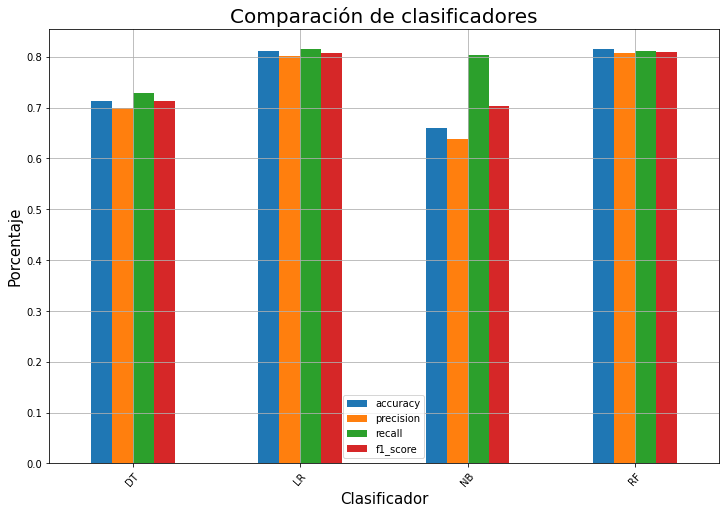

In [13]:
df.groupby('classifier').mean().plot.bar(figsize=(12,8), rot=48)
plt.title('Comparación de clasificadores', fontsize=20)
plt.xlabel('Clasificador', fontsize=15)
plt.ylabel('Porcentaje', fontsize=15)
plt.grid()
plt.savefig('./results/classifier_comparison.png')

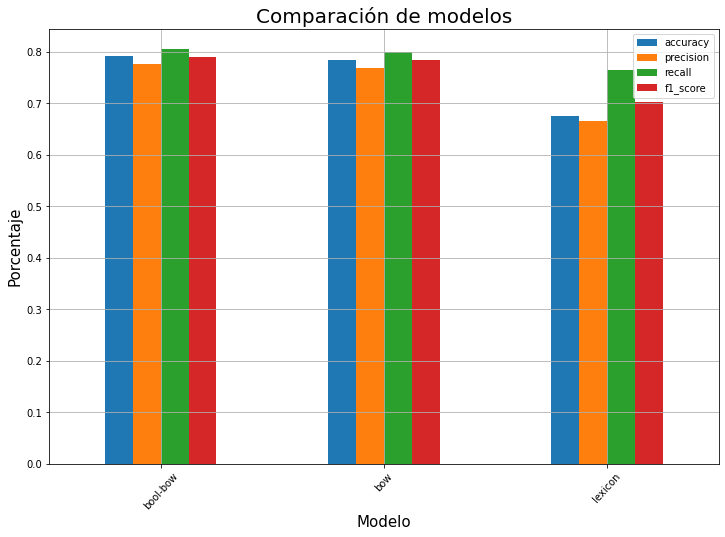

In [14]:
df.groupby('model').mean().plot.bar(figsize=(12,8), rot=48)
plt.title('Comparación de modelos', fontsize=20)
plt.xlabel('Modelo', fontsize=15)
plt.ylabel('Porcentaje', fontsize=15)
plt.grid()
plt.savefig('./results/model_comparison.png')

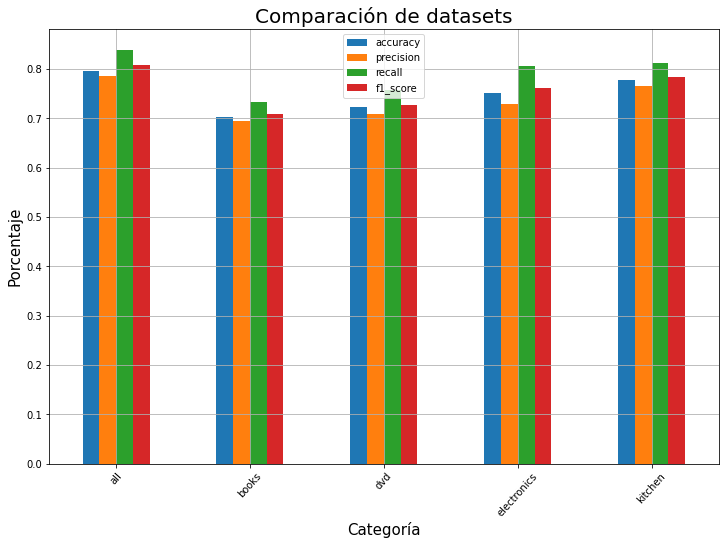

In [15]:
df.groupby('dataset').mean().plot.bar(figsize=(12,8), rot=48)
plt.title('Comparación de datasets', fontsize=20)
plt.xlabel('Categoría', fontsize=15)
plt.ylabel('Porcentaje', fontsize=15)
plt.grid()
plt.savefig('./results/datasets_comparison.png')

### Testing best models (test_dataset)

In [34]:
# Best model for books
path = './data/SA/books/bool-labeled.npy'
data = np.transpose(np.load(path))
X = data[:,:-1]
y = data[:,-1]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=15)
test = np.transpose(np.load('./data/SA/books/bool-unlabeled.npy'))
X_test = test[:,:-1]; y_test = test[:,-1]
clf = LogisticRegression(random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Expected accuracy in unknown dataset: %.3f' %(metrics.accuracy_score(y_test, y_pred)))
print('Expected precision in unknown dataset: %.3f' %(metrics.precision_score(y_test, y_pred)))
print('Expected recall in unknown dataset: %.3f' %(metrics.recall_score(y_test, y_pred)))
print('Expected f1-score in unknown dataset: %.3f' %(metrics.f1_score(y_test, y_pred)))

Expected accuracy in unknown dataset: 0.828
Expected precision in unknown dataset: 0.825
Expected recall in unknown dataset: 0.838
Expected f1-score in unknown dataset: 0.832


In [35]:
# Best model for kitchen
path = './data/SA/kitchen/labeled.npy'
data = np.transpose(np.load(path))
X = data[:,:-1]
y = data[:,-1]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=15)
test = np.transpose(np.load('./data/SA/kitchen/unlabeled.npy'))
X_test = test[:,:-1]; y_test = test[:,-1]
clf = LogisticRegression(random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Expected accuracy in unknown dataset: %.3f' %(metrics.accuracy_score(y_test, y_pred)))
print('Expected precision in unknown dataset: %.3f' %(metrics.precision_score(y_test, y_pred)))
print('Expected recall in unknown dataset: %.3f' %(metrics.recall_score(y_test, y_pred)))
print('Expected f1-score in unknown dataset: %.3f' %(metrics.f1_score(y_test, y_pred)))

Expected accuracy in unknown dataset: 0.874
Expected precision in unknown dataset: 0.875
Expected recall in unknown dataset: 0.871
Expected f1-score in unknown dataset: 0.873


In [37]:
# Best model for dvd
path = './data/SA/dvd/bool-labeled.npy'
data = np.transpose(np.load(path))
X = data[:,:-1]
y = data[:,-1]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=15)
test = np.transpose(np.load('./data/SA/dvd/bool-unlabeled.npy'))
X_test = test[:,:-1]; y_test = test[:,-1]
clf = RandomForestClassifier(random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Expected accuracy in unknown dataset: %.3f' %(metrics.accuracy_score(y_test, y_pred)))
print('Expected precision in unknown dataset: %.3f' %(metrics.precision_score(y_test, y_pred)))
print('Expected recall in unknown dataset: %.3f' %(metrics.recall_score(y_test, y_pred)))
print('Expected f1-score in unknown dataset: %.3f' %(metrics.f1_score(y_test, y_pred)))

Expected accuracy in unknown dataset: 0.808
Expected precision in unknown dataset: 0.781
Expected recall in unknown dataset: 0.861
Expected f1-score in unknown dataset: 0.819


In [38]:
# Best model for electronics
path = './data/SA/electronics/bool-labeled.npy'
data = np.transpose(np.load(path))
X = data[:,:-1]
y = data[:,-1]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=15)
test = np.transpose(np.load('./data/SA/electronics/bool-unlabeled.npy'))
X_test = test[:,:-1]; y_test = test[:,-1]
clf = LogisticRegression(random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Expected accuracy in unknown dataset: %.3f' %(metrics.accuracy_score(y_test, y_pred)))
print('Expected precision in unknown dataset: %.3f' %(metrics.precision_score(y_test, y_pred)))
print('Expected recall in unknown dataset: %.3f' %(metrics.recall_score(y_test, y_pred)))
print('Expected f1-score in unknown dataset: %.3f' %(metrics.f1_score(y_test, y_pred)))

Expected accuracy in unknown dataset: 0.863
Expected precision in unknown dataset: 0.861
Expected recall in unknown dataset: 0.869
Expected f1-score in unknown dataset: 0.865


In [45]:
# Best model for all
path = './data/SA/all/bool-labeled.npy'
data = np.transpose(np.load(path))
X = data[:,:-1]
y = data[:,-1]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=15)
test = np.transpose(np.load('./data/SA/all/bool-unlabeled.npy'))
X_test = test[:,:-1]; y_test = test[:,-1]
clf = RandomForestClassifier(random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Expected accuracy in unknown dataset: %.3f' %(metrics.accuracy_score(y_test, y_pred)))
print('Expected precision in unknown dataset: %.3f' %(metrics.precision_score(y_test, y_pred)))
print('Expected recall in unknown dataset: %.3f' %(metrics.recall_score(y_test, y_pred)))
print('Expected f1-score in unknown dataset: %.3f' %(metrics.f1_score(y_test, y_pred)))

Expected accuracy in unknown dataset: 0.843
Expected precision in unknown dataset: 0.858
Expected recall in unknown dataset: 0.823
Expected f1-score in unknown dataset: 0.840


### Most important feature for LR

In [63]:
LR_most_important = []
for LR in LR_coeffs:
    LR_most_important.append(np.argmax(LR))
dfLR = df[df['classifier']=='LR'].copy()
dfLR['most_important_feature'] = np.array(LR_most_important)
dfLR

,dataset,classifier,model,accuracy,precision,recall,f1_score,most_important_feature
books LR bow,books,LR,bow,0.81250,0.802030,0.814433,0.808184,14104
books LR bool-bow,books,LR,bool-bow,0.83250,0.829016,0.824742,0.826873,14104
books LR lexicon,books,LR,lexicon,0.72000,0.713542,0.706186,0.709845,2
dvd LR bow,dvd,LR,bow,0.82250,0.818653,0.814433,0.816537,13605
dvd LR bool-bow,dvd,LR,bool-bow,0.83500,0.829897,0.829897,0.829897,16958
dvd LR lexicon,dvd,LR,lexicon,0.72000,0.713542,0.706186,0.709845,2
electronics LR bow,electronics,LR,bow,0.86250,0.835749,0.891753,0.862843,9936
electronics LR bool-bow,electronics,LR,bool-bow,0.88250,0.851675,0.917526,0.883375,9936
electronics LR lexicon,electronics,LR,lexicon,0.72000,0.713542,0.706186,0.709845,2
kitchen LR bow,kitchen,LR,bow,0.91000,0.891089,0.927835,0.909091,8501


In [71]:
dict_bool = np.load('./data/SA/books/dictionary.npy')
print('most importante feature for books category: ' + dict_bool[14104])
dict_bool = np.load('./data/SA/dvd/dictionary.npy')
print('most importante feature for dvd category: ' + dict_bool[16958] + ' and ' + dict_bool[13605])
dict_bool = np.load('./data/SA/electronics/dictionary.npy')
print('most importante feature for electronics category: ' + dict_bool[9936])
dict_bool = np.load('./data/SA/kitchen/dictionary.npy')
print('most importante feature for kitchen category: ' + dict_bool[8501])
dict_bool = np.load('./data/SA/all/dictionary.npy')
print('most importante feature for all category: ' + dict_bool[29189])
print('for lexicon features the most important feature was # of neg words according to sentiwordnet')
print('for lexicon features the most important feature was # of pos words according to ANFII')

most importante feature for books category: excellent
most importante feature for dvd category: great and excellent
most importante feature for electronics category: great
most importante feature for kitchen category: great
most importante feature for all category: excellent
for lexicon features the most important feature was # of neg words according to sentiwordnet
for lexicon features the most important feature was # of pos words according to ANFII


### Testing random forest hyperparameteres

In [18]:
clfs_all_b = test_rf_hyperparameters('all', 'bool-bow')

# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'n_estimators': 332, 'max_features': 'log2'}

Grid scores on development set:

0.840 (+/-0.013) for {'n_estimators': 870, 'max_features': 'sqrt'}
0.841 (+/-0.013) for {'n_estimators': 981, 'max_features': 'auto'}
0.840 (+/-0.013) for {'n_estimators': 870, 'max_features': 'auto'}
0.839 (+/-0.017) for {'n_estimators': 692, 'max_features': 'auto'}
0.841 (+/-0.013) for {'n_estimators': 919, 'max_features': 'auto'}
0.840 (+/-0.016) for {'n_estimators': 686, 'max_features': 'sqrt'}
0.843 (+/-0.010) for {'n_estimators': 332, 'max_features': 'log2'}
0.840 (+/-0.013) for {'n_estimators': 783, 'max_features': 'sqrt'}
0.839 (+/-0.011) for {'n_estimators': 401, 'max_features': 'auto'}
0.840 (+/-0.013) for {'n_estimators': 967, 'max_features': 'auto'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision  

In [19]:
clfs_all = test_rf_hyperparameters('all', 'bow')

# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'n_estimators': 722, 'max_features': 'log2'}

Grid scores on development set:

0.827 (+/-0.008) for {'n_estimators': 98, 'max_features': 'sqrt'}
0.841 (+/-0.014) for {'n_estimators': 384, 'max_features': 'sqrt'}
0.826 (+/-0.017) for {'n_estimators': 195, 'max_features': 'log2'}
0.840 (+/-0.011) for {'n_estimators': 967, 'max_features': 'auto'}
0.835 (+/-0.010) for {'n_estimators': 165, 'max_features': 'auto'}
0.844 (+/-0.018) for {'n_estimators': 722, 'max_features': 'log2'}
0.830 (+/-0.012) for {'n_estimators': 212, 'max_features': 'log2'}
0.841 (+/-0.013) for {'n_estimators': 868, 'max_features': 'sqrt'}
0.841 (+/-0.015) for {'n_estimators': 438, 'max_features': 'auto'}
0.839 (+/-0.010) for {'n_estimators': 180, 'max_features': 'sqrt'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision   

In [20]:
clfs_all_l = test_rf_hyperparameters('all', 'lexicon')

# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'n_estimators': 103, 'max_features': 'auto'}

Grid scores on development set:

0.989 (+/-0.006) for {'n_estimators': 332, 'max_features': 'sqrt'}
0.989 (+/-0.006) for {'n_estimators': 609, 'max_features': 'sqrt'}
0.989 (+/-0.006) for {'n_estimators': 997, 'max_features': 'sqrt'}
0.989 (+/-0.006) for {'n_estimators': 416, 'max_features': 'auto'}
0.989 (+/-0.006) for {'n_estimators': 817, 'max_features': 'auto'}
0.989 (+/-0.006) for {'n_estimators': 981, 'max_features': 'sqrt'}
0.989 (+/-0.006) for {'n_estimators': 438, 'max_features': 'auto'}
0.989 (+/-0.006) for {'n_estimators': 238, 'max_features': 'auto'}
0.990 (+/-0.006) for {'n_estimators': 103, 'max_features': 'auto'}
0.989 (+/-0.006) for {'n_estimators': 692, 'max_features': 'sqrt'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision  

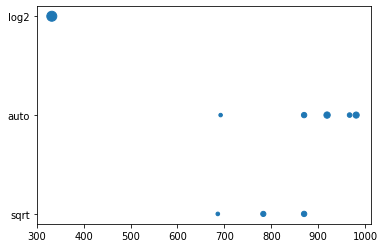

In [21]:
clf = clfs_all_b[0]
s = (clf.cv_results_['mean_test_score']-min(clf.cv_results_['mean_test_score']))/max(clf.cv_results_['mean_test_score']-min(clf.cv_results_['mean_test_score']))
plt.scatter(clf.cv_results_['param_n_estimators'],
            clf.cv_results_['param_max_features'], 
            s = s*100)

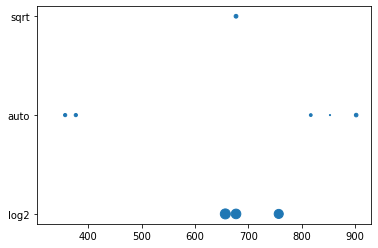

In [22]:
clf = clfs_all_b[1]
s = (clf.cv_results_['mean_test_score']-min(clf.cv_results_['mean_test_score']))/max(clf.cv_results_['mean_test_score']-min(clf.cv_results_['mean_test_score']))
plt.scatter(clf.cv_results_['param_n_estimators'],
            clf.cv_results_['param_max_features'], 
            s = s*100)

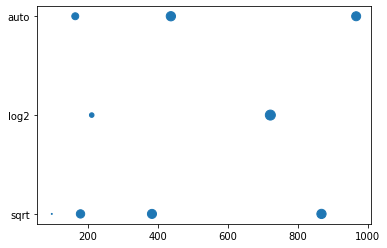

In [23]:
clf = clfs_all[0]
s = (clf.cv_results_['mean_test_score']-min(clf.cv_results_['mean_test_score']))/max(clf.cv_results_['mean_test_score']-min(clf.cv_results_['mean_test_score']))
plt.scatter(clf.cv_results_['param_n_estimators'],
            clf.cv_results_['param_max_features'], 
            s = s*100)

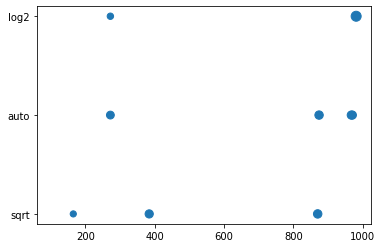

In [24]:
clf = clfs_all[1]
s = (clf.cv_results_['mean_test_score']-min(clf.cv_results_['mean_test_score']))/max(clf.cv_results_['mean_test_score']-min(clf.cv_results_['mean_test_score']))
plt.scatter(clf.cv_results_['param_n_estimators'],
            clf.cv_results_['param_max_features'], 
            s = s*100)

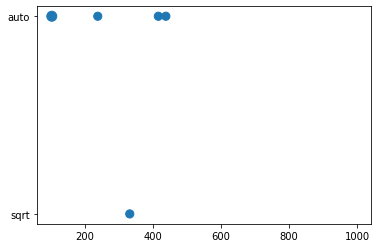

In [25]:
clf = clfs_all_l[0]
s = (clf.cv_results_['mean_test_score']-min(clf.cv_results_['mean_test_score']))/max(clf.cv_results_['mean_test_score']-min(clf.cv_results_['mean_test_score']))
plt.scatter(clf.cv_results_['param_n_estimators'],
            clf.cv_results_['param_max_features'], 
            s = s*100)

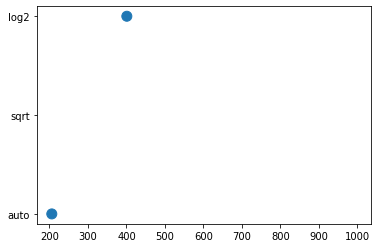

In [26]:
clf = clfs_all_l[1]
s = (clf.cv_results_['mean_test_score']-min(clf.cv_results_['mean_test_score']))/max(clf.cv_results_['mean_test_score']-min(clf.cv_results_['mean_test_score']))
plt.scatter(clf.cv_results_['param_n_estimators'],
            clf.cv_results_['param_max_features'], 
            s = s*100)